In [1]:
from functools import partial

from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Run the following before any XLA modules such as JAX:
import chex

chex.set_n_cpu_devices(2)

# Import the remaining JAX related
from mubelnet.mcmc import sample_markov_chain
from mubelnet.nets import MultinomialBelief
from mubelnet.utils import freeze_trainable_states, holdout_split, perplexity

import haiku as hk
import jax
from jax import random
import jax.numpy as jnp

2023-11-24 13:27:54.692910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


To illustrate how to use the multinomial belief network, we will train the
model on the UCI ML datasets, containing handwritten digits.

The dataset can directly be loaded from scikit-learn. As preprocessing step, we reshape the
digits from a 8x8 square matrix to a flat array of size 64.

In [2]:
digits = datasets.load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
X_train, X_test = train_test_split(X, test_size=0.2, random_state=0)

Next, we define the model. We use a simple decoder network with two hidden layers. In
total, the size of the network: 2 x 10 x 64.

```
hidden_units = (2, 10)
model = MultinomialBelief(hidden_units, n_features)
```

This function has to be defined in a [haiku](https://github.com/deepmind/dm-haiku) context to transform the network in a pure state for JAX.

Since the network is a Bayesian model, we don't train the model by
minimising a loss. Rather, we infer the distribution $p(\boldsymbol{\theta}|\boldsymbol{X}_{\mathrm{train}})$ of the model's parameters $\boldsymbol{\theta}$ given the training data $\boldsymbol{X}_{\mathrm{train}}$ that we observe. This probability distribution is called the [posterior](https://en.wikipedia.org/wiki/Posterior_probability).

Unfortunately, we don't know what this distribution is. However, we do know a way how to sample it: using Markov chain Monte Carlo (MCMC). This simulation method samples the distributions by taking small steps that depend on its previous state. In theory, when we have take enough steps, the state converges to the true (posterior) distribution.

To take one step, you simply call your model using
the training data:

```python
model(X_train)
```

This function call does one Gibbs sampling step, which updates all the parameters one-by-one. The initialisation of the chain  (which are initialised with ancesetral samples) is automatically taken care for you.

Now, lets put all elements together.

In [3]:
# Pseudo-random number generator sequence.
key_seq = hk.PRNGSequence(42)

m_samples, n_features = X_train.shape

@hk.transform_with_state
def kernel(X=X_train, training=True):
    """Advance the Markov chain by one step."""
    hidden_units = (2, 10)
    model = MultinomialBelief(hidden_units, n_features)
    # Do one Gibbs sampling step.
    model(X)

Here, we defined a function that proposes a new state based on its current configuration. This is called a _kernel_. The `hk.transform_with_state` decorator uses haiku to purify the function into something that is stateless.

Finally, we draw samples from the Markov chain. We first take 100 burn-in steps, in the
hope that the chain converges to the true distribution. After throwing away these first 100 samples, we collect a new set
of 50 samples (25 in each chain) to estimate the posterior distribution.

Note that `sample_markov_chain` (below) automatically takes care of distributing your
computation across multiple devices. For simplicity, we assume you are running on a CPU and split the CPU up in two virtual devices. (See above, at the import section, where we've used
`chex` set the number of devices to 2.)

The following cell, that collects statistics from the Markov chain takes, about `10 minutes` to run on a CPU.

In [4]:
n_chains = jax.device_count()

params, states = sample_markov_chain(
    next(key_seq),
    kernel=kernel,
    n_samples=50,
    n_burnin_steps=100,
    n_chains=n_chains,
)

_ = states['multinomial_belief/~/multinomial_layer']['phi'].block_until_ready()

/home/hylke/.local/lib/python3.11/site-packages/mubelnet/random.py:326: UserWarning: Explicitly requested dtype float64 requested in zeros_like is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  x_jk = jnp.zeros_like(b.transpose(), dtype=x.dtype)
/home/hylke/.local/lib/python3.11/site-packages/mubelnet/random.py:344: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  x_pad = jnp.zeros((n_pad, x.shape[1]), x.dtype)
/home/hylke/.local/lib/python3.11/site-packages/mubelnet/random.py:326: UserWarning: Explicitly requested dtype float64 requested in zeros_like

After training the model, we can inspect what the model has learned. Note that, instead of a single point estimate of the parameters, we've obtained a distribution. To visualise the parameters, we take for simplicity the median. Let's take a look at $\bm{\Phi}^{(1)}$, the weights of the first layer.

<Figure size 640x480 with 0 Axes>

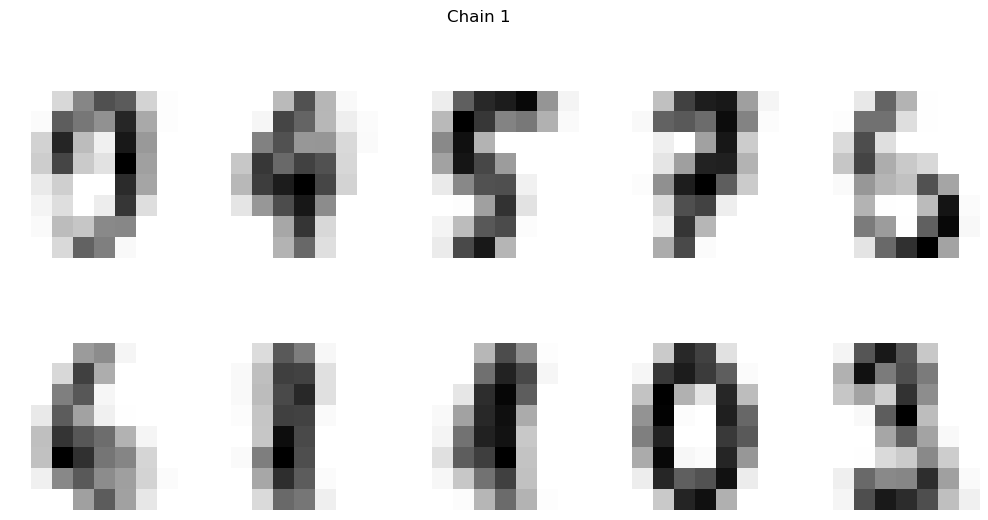

<Figure size 640x480 with 0 Axes>

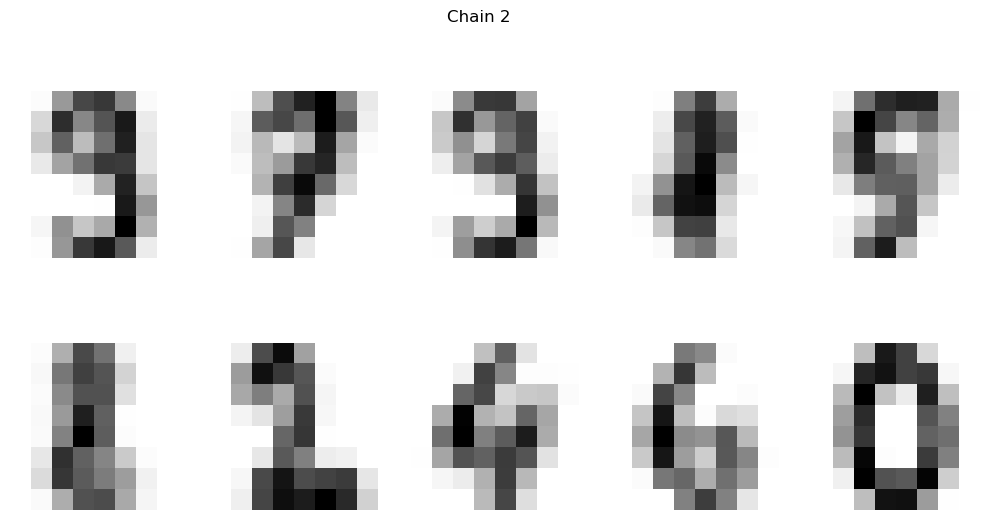

In [7]:
# Aggregate posterior samples to visualise.
phi_1st_layer = np.mean(states['multinomial_belief/~/multinomial_layer']['phi'], axis=[1])

for i in range(n_chains):  # For each Markov chain.
    plt.figure()
    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(12.5, 6))
    plt.suptitle(f'Chain {i+1}')
    # Plot the weights of all 10 hidden states.
    for ax, phi in zip(axes.flatten(), phi_1st_layer[i]):
        ax.set_axis_off()
        image = phi.reshape(8, 8)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")

# Test perplexity.
Given a distribution $p(x)$, perplexity is defined as $\mathcal{L} = \exp(S[p])$ with $S[p]$ the entropy of distribution $p(x)$. In practice, we evaluate the cross entropy with the emperical distribution so that
$$
\ln \mathcal{L} = -E_{\mathrm{\pmb{x}}}[ \ln p(\pmb{x}|\pmb{X}_{\mathrm{train}})] \approx -\frac{1}{m}\sum_{i=1}^{m} \ln p(\pmb{x}^{(i)}|\pmb{X}_{\mathrm{train}})
$$

To this end, we split the data in three sets: A training set $\pmb{X}_{\mathrm{train}}$, and two tests sets $\pmb{X}_{\mathrm{test}}^{A}$ and $\pmb{X}_{\mathrm{test}}^{B}$ containing 50% of the pixel intensities each (so that $\pmb{X}_{\mathrm{test}} = \pmb{X}_{\mathrm{test}}^A + \pmb{X}_{\mathrm{test}}^B$), similar to Ref. [1]. 

[1]: Wang, Chong, John Paisley, and David M. Blei. "Online variational inference for the hierarchical Dirichlet process." Proceedings of the fourteenth international conference on artificial intelligence and statistics. JMLR Workshop and Conference Proceedings, 2011.

In [8]:
X_test_A, X_test_B = holdout_split(next(key_seq), X_test)

We then use $\pmb{X}_{\mathrm{train}}$ to infer the sample independent parameters $\bm{\phi}, \bm{r}, c$ (i.e., without sample index $i$). With these, we use $\pmb{X}_{\mathrm{test}}^A $ to infer the sample _dependent_ parameters $\pmb{\theta}$ (i.e., with index $i$). Finally, we use $\pmb{X}_{\mathrm{test}}^{B}$ to estimate $p(\pmb{x}|\pmb{X}_{\mathrm{train}})$.


Specifically, we model the probabilities as categories $p(x_{ij}|\pi_{ij}) = \pi_{ij}^{x_{ij}}$ where $\pi_{ij}$ is the probability to observe pixel intensity $j$ in sample $i$.

In [9]:
def probability(params, state):
    bottom_params = params.get("multinomial_belief/~/multinomial_layer", {})
    bottom_state = state["multinomial_belief/~/multinomial_layer"]
    phi = bottom_params.get("phi", bottom_state.get("phi"))
    theta = bottom_state["copy[theta(1)]"]
    return theta @ phi

We estimate $\pi_{ij}$ by averaging the posterior samples:
$$
\pi_{ij}(\pmb{X}_{\mathrm{train}}, \pmb{X}_{\mathrm{test}}^A ) 
= \int \mathrm{d}\pmb{\phi} \, \mathrm{d}\pmb{\theta} \, p(x_{ij}|\pmb{\phi}\pmb{\theta}) p(\pmb{\theta} | \pmb{\phi}, \pmb{r}, c, \pmb{X}_{\mathrm{test}}^A ) p(\pmb{\phi}, \pmb{r}, c|\pmb{X}_{\mathrm{train}}) 
\approx \frac{1}{S R} \sum_{s=1}^S \sum_{r=1}^{R} \sum_{k=1}^K \theta_{ik}^{(s, r)} \phi_{kj}^{(s)}
$$
where $\phi_{kj}^{(s)}$ with $s=1,\dots,S$ denote posterior samples based on the training set $\pmb{X}_{\mathrm{train}}$ and $\theta_{ik}^{(s, r)}$ the posterior samples $r=1,\dots,R$ with respect to $\pmb{X}_{\mathrm{test}}^A $ given $\phi_{kj}^{(s)}$ .

Having inferred $\pmb{\phi}|\pmb{X}_{\mathrm{train}}$ above, let's infer $\pmb{\theta} | \pmb{\phi}, \pmb{r}, c, \pmb{X}_{\mathrm{test}}^A$ for all the different realisations.

In [10]:
# Lift our the parameters r, c, and phi to keep them fixed.
test_params, _ = freeze_trainable_states(states)

# Configure Markov chain kernel for X_test_a with clamped parameters (training=False).
init_test_fn = jax.jit(jax.vmap(partial(kernel.init, X=X_test_A, training=False)))
kernel_test_fn = partial(kernel.apply, X=X_test_A, training=False)

# Do inference on X_test_A for each posterior sample individually.
probs = []
for i in range(n_chains):
    probs_i = []
    for j in range(25):
        params_s = jax.tree_util.tree_map(lambda x: x[i, j], test_params)
        # Randomly initialise Markov chain.
        keys_per_chain = random.split(next(key_seq), num=n_chains)
        _, states_test_s_r = init_test_fn(keys_per_chain)
        # Sample Markov chain.
        _, states_test_s_r = sample_markov_chain(
            next(key_seq),
            n_samples=10,
            kernel=kernel_test_fn,
            params=params_s,
            initial_state=states_test_s_r,
            n_burnin_steps=20,
        )
        _ = states_test_s_r['multinomial_belief/~/cap_layer']['theta'].block_until_ready()
        probs_ij = probability(params_s, states_test_s_r)
        probs_i.append(probs_ij)
    probs.append(jnp.stack(probs_i))

probs = jnp.stack(probs)

Finally, the per intensity perplexity is computed on the separate hold-out set $\pmb{X}_{\mathrm{test}}^B$:
$$
\mathcal{L}\left(\pmb{X}_{\mathrm{test}}^B| \pmb{\pi}\right) = \exp \left(-\frac{1}{m} \sum_{i=1}^m \sum_{j=1}^n \frac{x_{ij} \ln {\pi}_{ij}}{\sum_{j=1}^n x_{ij}} \right).
$$

In [11]:
probs_train = jnp.mean(probability(params, states), axis=(0, 1))
print(f'Training set perplexity: {perplexity(X_train, probs_train):.2f}')

Training set perplexity: 33.99


In [12]:
probs_test = probs.mean(axis=[0, 1, 2, 3])
print(f'Test set perplexity: {perplexity(X_test_B, probs_test):.2f}')

Test set perplexity: 40.94
